# Predicting Churn at Telco

by Kristofer Rivera
2022-03-14

## Project Overview

### Project Objectives
- The goal of this project is to find drivers of churn at Telco and answer the question: "Why are customers churning? 
- Construct a Machine Learning classification model that can accurately predict customer churn.
- Deliver a report that clearly lays out findings and insights, and summarizes the process taken to reach them.
- Present recommendations to stakeholders.


### Project Description

Telco, a telecommunications company, is churning customers at a rate of about 27% percent. They want to find out why customers are churning and what changes they can make to reduce customer churn. The minimum viable product is a machine learning model that can accurately predict customer churn at a rate above the baseline and can be used to make recommendations for potential changes.



In [1]:
#Imports for statistical analysis
from scipy import stats
import statistics

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns


## Wrangle Telco Data

To acquire the telco data, I used the telco_churn database in our mySQL server. I selected all columns from the customers table and joined with the contract_types, payment_types, and internet_service types tables.

`SELECT * FROM customers
        JOIN contract_types USING (contract_type_id)
        JOIN payment_types USING (payment_type_id)
        JOIN internet_service_types USING (internet_service_type_id);`. 

In [2]:
# acquire data from sql database 
import acquire as aq
 
# make the connection the database and run the query and return the table in the form of a dataframe. 
telco = aq.get_telco_data()

Using cached csv...


To clean the data, I did the following: 

1. Removed leading/trailing white space from total_charges and converted it from an object to a float data type.
2. Removed rows where tenure and total_charges = 0
3. Encoding (Changing Yes to 1 and No to 0)
4. Creating dummy variables for 'gender', 'contract_type', 'payment_type', 'internet_service_type'
5. Concatenating the dummy variables
6. Dropped redundant columns: contract_type_id, payment_type_id, internet_service_type_id and renamed other columns for clarity
- Results:
  - 7043 Rows
  - 29 Columns 

In [3]:
import warnings
warnings.filterwarnings("ignore")

import prepare as prep
import pandas as pd

#Use prepare.py to clean and split data frame
df = prep.prep_telco(telco)
train, validate, test = prep.split_telco_data(df)

- Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data. 
- The validate is used to verify that our models built are not overfit to the train dataset. 
- The test set is used to give an estimate of how this model will perform on data is has never seen in the future. 

In [4]:
# Show how the data has been split up
print(train.shape)
print(validate.shape)
print(test.shape)

(3937, 29)
(1688, 29)
(1407, 29)


## Set the Data Context

26% of customers churned. We have data from 7043 customers, 3875 of which are on monthly contracts, and the average monthly charges of all customers was $64.80. 

In [5]:
#import file with predefined functions for exploring my data
import explore as ex

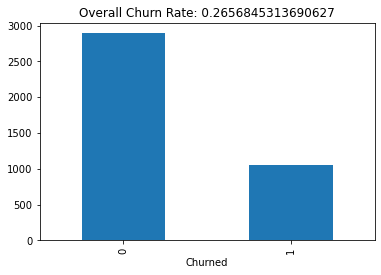

In [6]:
#Creating a bar polot that demonstrates the distribution of churn in our population
train.churn.value_counts().sort_index().plot.bar()
churn_rate = train.churn.mean()
plt.title(f'Overall Churn Rate: {churn_rate}')
plt.xlabel('Churned')
plt.show()

## Exploratory Analysis: Who was more likely to churn? 

*I started exploratory analysis by examning the correlations of all by variables with cutomer churn.*

Text(0, 0.5, 'Correlation')

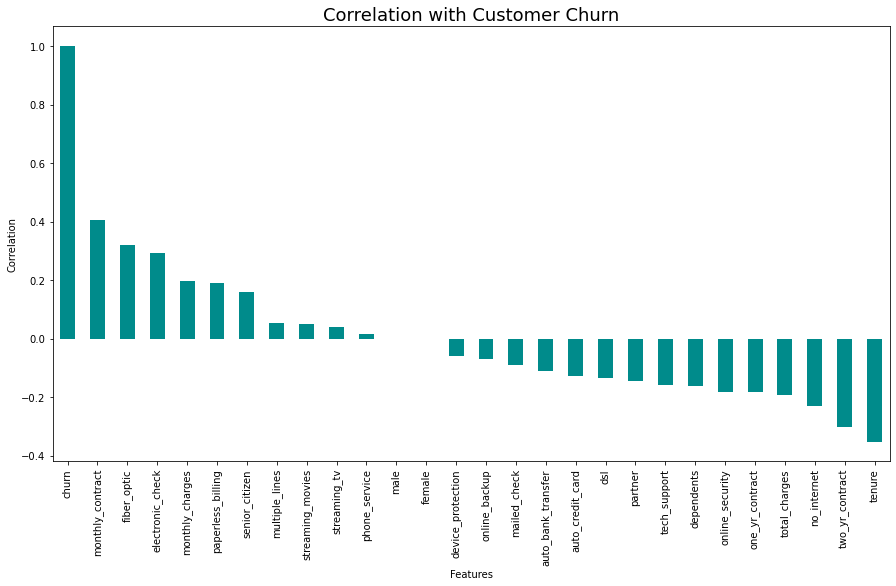

In [7]:
plt.figure(figsize= (15, 8))
train.corr()['churn'].sort_values(ascending=False).plot(kind='bar', color = 'darkcyan')
plt.title('Correlation with Customer Churn', fontsize = 18)
plt.xlabel('Features')
plt.ylabel('Correlation')

I have answered these questions

1. Is there a service type more associated with churn than expected?
2. Is a certain payment or contract type associated with higher churn?
3. Do customers who churn have higher average monthly charges?
4. Do monthly charges increase with tenure? How does this affect churn?

### Question 1

Is there a service type more associated with churn than expected?

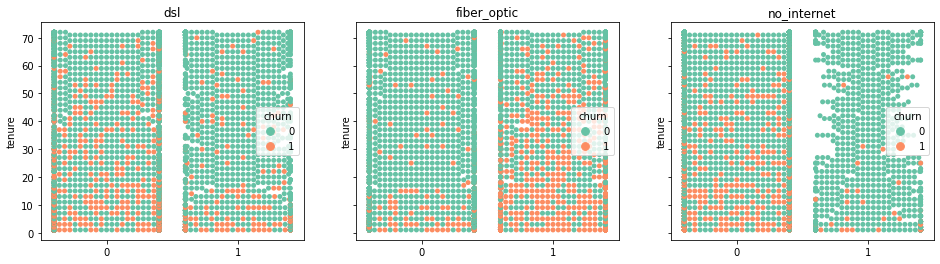

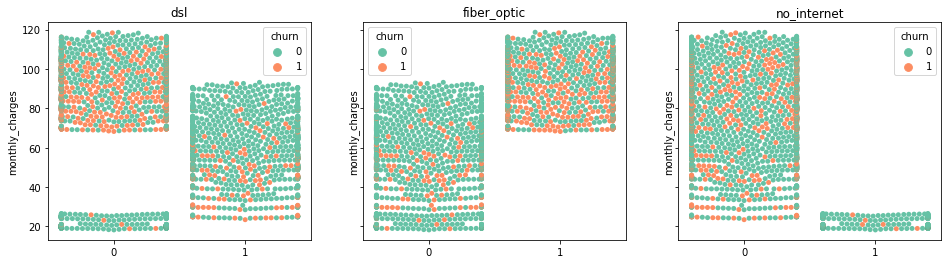

In [8]:
#Conduct multivariate statistic visualiazation
target = 'churn'
cat_vars = ['dsl', 'fiber_optic', 'no_internet']
quant_vars = ['tenure', 'monthly_charges']

ex.plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
plt.show()

*I conducted a chi2 test to confirm that churn is dependent on suing fiber optic service.*

$H0$: Having fiber optic service is independent of churning.

$Ha$: Having fiber optic service and churning are dependent on eachother. They are correlated.

In [9]:
#Chi Square test on fiber_optic vs Churn
cat_var = 'fiber_optic'
target= 'churn'
observed = pd.crosstab(train[cat_var], train[target])

In [10]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(405.92112170517066, 2.831419548361709e-90)

**The p-value is less than an alpha of .05. We can reject the null hypothesis that the variables are independent of eachother. There is a statistical correlation between fiber optic service and churn.**

### Answer 1
- There is a higher rate of churn for customers with fiber optic internet plan.
- Fiber optic seems has higher monthly charges on average.

### Question 2

Is a certain payment or contract type associated with higher churn?

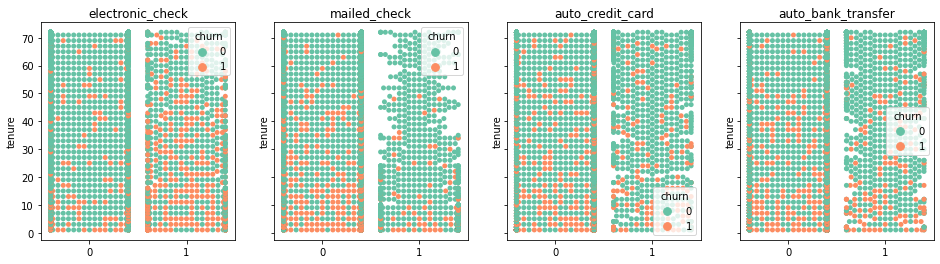

In [11]:
#Conduct multivariate statistic visualization
cat_vars = ['electronic_check', 'mailed_check', 'auto_credit_card', 'auto_bank_transfer']
quant_vars = ['tenure']

ex.plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
plt.show()

*I conducted a chi2 test to confirm that paying by churn is dependent on paying by electronic check.*

$H0$: Paying by electronic check is independent of churning.

$Ha$: Paying by electronic check and churning are dependent on eachother. They are correlated.

In [12]:
#Chi Square test on electronic_check vs Churn
cat_var = 'electronic_check'
target= 'churn'
observed = pd.crosstab(train[cat_var], train[target])
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(334.97978026680926, 7.910587922260644e-75)

**The p-value is less than an alpha of .05. We can reject the null hypothesis that the variables are independent of eachother. There is a statistical correlation between paying by electronic check and churn.**

### Answer 2
- Those who pay by electronic check churn at a much higher rate than other payment types. 
- Mailed checks, and the automatic payments types don't seem to be significantly correlated with churn. 

### Question 3

Do customers who churn have higher average monthly charges?

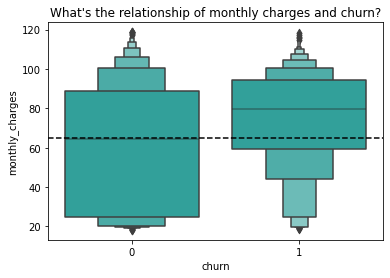

In [13]:
#establish our variable
quant_var = 'monthly_charges'

#plot a boxplot using a predefined function
ex.plot_boxen(train, target, quant_var)
plt.title("What's the relationship of monthly charges and churn?")
plt.show()

### Answer 3
-  Average monthly charges are higher among customers who churned.

### Question 4
Do monthly charges increase with tenure? How does this affect churn?

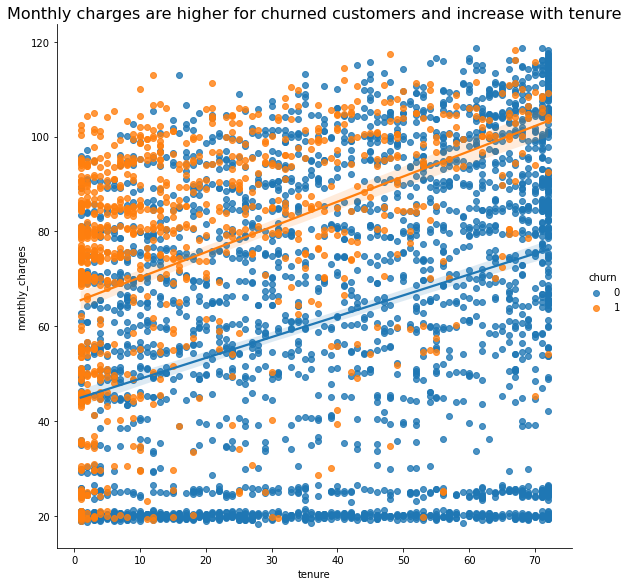

In [14]:
sns.lmplot(x = 'tenure', y= 'monthly_charges', hue='churn', data=train, size = 8)
plt.title('Monthly charges are higher for churned customers and increase with tenure', fontsize= 16)
plt.show()

### Answer 4

- Monthly charges increase with tenure, and customers who churned have higher monthly charges.

### Summary: So, who IS most likely to churn? 

Through exploratory visualizations and statistical correlation test I determined the five top drivers of churn were:


'electronic_check', 'monthly_contract', 'fiber_optic', 'monthly_charges', 'paperless_billing'

## Predicting Churn

Because churn is a boolean/yes or no value, we will use classification machine learning algorithms to fit to our training data and we will evaluate on validate. We will pick the best model using accuracy <evaluation metric> because the data is mostly balanced, and the risk of an event happening balances the risk of getting a prediction wrong. 
    
### Baseline

I will set a baseline prediction by predicting all customers to not churn (churn == 0) since most customers are currently not churning. I will evaluate future models against this accuracy.

In [15]:
# Calculate the baseline for train data set

baseline = (train.churn == 0).mean()
print(f'Our baseline accuracy is {baseline}. We can compare our model accuracy to this figure.')

Our baseline accuracy is 0.7343154686309372. We can compare our model accuracy to this figure.


Baseline performed at 73% accuracy

### Fit 3 models

The top 3 models we built were a decision tree, and two logistic regression models.
The logistic regression had the best performance while maintaing the least dimensionality.
It had a 76% accuracy beating the baseline.

In [16]:
#Imports for modeling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#imports for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [17]:
#Use prepare.py to create x and y variables
X_train, y_train, X_validate, y_validate, X_test, y_test = prep.create_xy(train, validate, test)

**I trained 14 models on the train data and evaluated them on the validate set. Models used different combinations of features and paramaters and included decision tree, random forest, K-neighers neighbor, and logistic regression models.**

*Some models used all features, some the top 5 drivers, and some only the top 2 drivers*

I calculated the accuracy score of all those models listed here:

- Model 1: 0.7263
- Model 2: 0.7731
- Model 3: 0.7594
- Model 4: 0.7417
- Model 5: 0.7713
- Model 6: 0.7979
- Model 7: 0.7233
- Model 8: 0.7434
- Model 9: 0.7316
- Model 10: 0.7334
- Model 11: 0.7191
- Model 12: 0.7588
- Model 13: 0.7387
- Model 14: 0.7387

**These were the top 3 scores:**

Using all features:
- Model 6: 0.80 -- Logistic Regression
- Model 2: 0.77 -- Decision Tree, Max Depth 3

Using top 5 features:
- Model 12: 0.76 -- Logistic Regression

### Model 2

In [18]:
#Model 2

clf2 = DecisionTreeClassifier(max_depth=3, random_state=123)

clf2 = clf2.fit(X_train, y_train)

# Creating predictions and evaluating 
X = X_validate
y = y_validate

accuracy2 = clf2.score(X, y)
accuracy2

0.7731042654028436

*This model uses all features and as such is susceptible to being overfit.*

### Model 6

In [19]:
# Model 6
# Create our logistic regression model 

logit1 = LogisticRegression(random_state=123)
logit1 = logit1.fit(X_train, y_train)

#Calculate accuracy
accuracy6 = logit1.score(X, y)
accuracy6

0.7979857819905213

*This model uses all features and as such is susceptible to being overfit.*

### Model 12 - Evaluated on Test

**I ultimately chose to select Model 12 which is a logistic regression with the top 5 drivers helping reduce dimensionality and the risk of overfitting.**

In [20]:
# Model 12
#Create logistic regresssion model fitted to train set

#create a variable for our top 5 features

top_5_features=['electronic_check', 'monthly_contract', 'fiber_optic', 'monthly_charges', 'paperless_billing']

logit3 = LogisticRegression(random_state=123)
logit3 = logit3.fit(X_train[top_5_features], y_train)

In [21]:
# Evaluating Model 12 on test 

X = X_test[top_5_features]
y = y_test 

accuracy12 = logit3.score(X, y)
y_pred = logit3.predict(X)
conf = confusion_matrix(y, y_pred)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()
print(f'''
The accuracy for our model is {accuracy12:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7612
The True Positive Rate is 0.529, The False Positive Rate is 0.155,
The True Negative Rate is 0.845, and the False Negative Rate is 0.471



,precision,recall,f1-score,support
0,0.832221,0.845111,0.838617,1033.000000
1,0.553073,0.529412,0.540984,374.000000
accuracy,0.761194,0.761194,0.761194,0.761194
macro avg,0.692647,0.687262,0.689800,1407.000000
weighted avg,0.758020,0.761194,0.759502,1407.000000


### Visualizing our models's accuracy

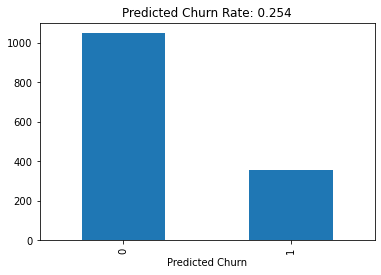

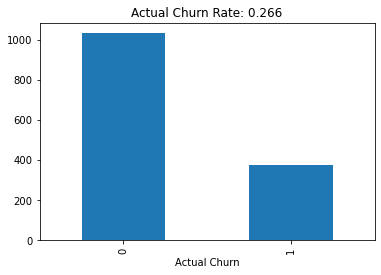

In [22]:
# Create a copy of test dataframe
test_predictions = test.copy()
test_predictions['prediction'] = y_pred
# Create dataframe for visualization purposes
prediction_vis = test_predictions[['customer_id', 'churn', 'prediction']]
prediction_vis = prediction_vis.rename(columns={'churn': 'actual_churn'})

#Create bar plots comparing the models predicted church vs actual churn 
prediction_vis.prediction.value_counts().sort_index().plot.bar()
predicted_churn_rate = prediction_vis.prediction.mean()
plt.title(f'Predicted Churn Rate: {predicted_churn_rate:.3}')
plt.xlabel('Predicted Churn')
plt.show()

prediction_vis.actual_churn.value_counts().sort_index().plot.bar()
actual_churn_rate = prediction_vis.actual_churn.mean()
plt.title(f'Actual Churn Rate: {actual_churn_rate:.3}')
plt.xlabel('Actual Churn')
plt.show()

I expect this model to perform with 76% accuracy in the future on data it has not seen, given no major changes in our data source. 

## Conclusion

The top drivers of customer churn are: 

1. Customers who pay by electronic check vs by mailed checks or automatic forms of payment.
2. Customers on a monthly contract are much more liklely to chur than those on yearly contracts.
3. Customers who have a fiber optic internet service plan are more likely to churn than those who use DSL or do not have internet service.
4. Customers who churn have higher average monthly charges.

A logistic regression model using our top drivers of churn as its features is able to predict churn with 76% accuracy.

### Recommendations

I recommend sharing these insights and this model with customer service representatives to infom the way they support Telco customers.

Some ideas I would suggest for reducing churn:
- Incentivize customers to switch to automatic forms of payment.
- Offer higher dicounts for yearly contracts to incentivize a switch away from monthly contracts.

### Next Steps

- Investigate why fiber optic plans have such a high churn rate. Is service spotty or unreliable? Do fiber optic prices need to be reduced to retain customers on the plan for longer?
- Create a customer survey that would help determine porper pricing of services, whether or not their is a customer service issue, and potentially identify any other drivers or variables not included in our data set.
